In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

mapping = {}
with open("dataset/emnist-byclass-mapping.txt") as f:
    for line in f:
        label, ascii_code = line.strip().split()
        mapping[int(label)] = chr(int(ascii_code))

def label_to_char(label):
    return mapping.get(label, None)

# === Model Definition (same as training) ===
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Device config (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Test Data for batch inference ===
test_data = pd.read_csv("dataset/emnist-byclass-test.csv", header=None)
true_labels = test_data.iloc[:, 0].values  # True labels for checking accuracy
images = test_data.iloc[:, 1:].values.reshape(-1,28,28,1).astype('float32') / 255.0
images_torch = torch.from_numpy(images).permute(0,3,1,2)

# Test transforms (for batch and single images)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# === Custom Dataset for Test Images ===
from torch.utils.data import Dataset, DataLoader

class EMNISTTestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_tensor = self.images[idx]
        img_np = img_tensor.numpy()
        if img_np.ndim == 3 and img_np.shape[0] == 1:
            img_np = img_np.squeeze(0)
        elif img_np.ndim == 3 and img_np.shape[-1] == 1:
            pass
        elif img_np.ndim != 2:
            raise ValueError(f"Unexpected image shape: {img_np.shape}")
        if self.transform:
            img_out = self.transform(img_np)
        else:
            img_out = torch.tensor(img_np)
        return img_out

batch_size = 32
test_dataset = EMNISTTestDataset(images_torch, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# === Load Trained Model ===
num_classes = 62
model = CNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("cnn_model.pth", map_location=device))
model.eval()

# === Batch Inference ===
all_predicted_labels = []
with torch.no_grad():
    for batch_x in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted_labels.extend(predicted.cpu().numpy())

predicted_chars = [label_to_char(lbl) for lbl in all_predicted_labels]

# === Check accuracy and print summary ===
correct = sum(p == t for p, t in zip(all_predicted_labels, true_labels))
total = len(true_labels)
accuracy = (correct / total) * 100
print(f"Prediction Accuracy: {accuracy:.2f}%\n")

# === Save batch predictions to CSV ===
output_df = pd.DataFrame({"Predicted": predicted_chars})
output_df.to_csv("emnist_predictions.csv", index=False)


Prediction Accuracy: 85.98%



In [2]:
from PIL import Image
import numpy as np
import torch

def predict_character_from_flat(flat_array):
    """
    Predict an EMNIST character from a flat 784-length array (pixels) using a trained model.

    Args:
        flat_array (list or np.ndarray): Length-784 pixel values (0-255) for a single 28x28 image.

    Returns:
        str: Predicted character.
    """
    # Step 1: Convert flat array to numpy and reshape to 28x28
    img_np = np.array(flat_array, dtype=np.uint8).reshape(28, 28)
    
    # Step 2: Convert to PIL Image (grayscale)
    pil_img = Image.fromarray(img_np)

    # Step 4: Resize (redundant here but safe for general use)
    pil_img = pil_img.resize((28, 28), Image.Resampling.LANCZOS)
    
    # Step 5: Convert to tensor, normalize to [0,1]
    img_tensor = transforms.ToTensor()(pil_img).unsqueeze(0).to(device) # Add batch dimension
    
    # Step 6: Model inference
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_label = torch.max(output.data, 1)
        predicted_label = predicted_label.item()
    
    # Step 7: Decode to character
    char = label_to_char(predicted_label)
    return char



In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_flat_image(flat_array, cmap='gray'):
    """
    Display a 784-length flat pixel array as a 28x28 image.
    Args:
        flat_array (list or np.ndarray): Length-784 pixel values (0-255 or normalized 0-1).
        cmap (str): Matplotlib color map ('gray' by default).
    """
    if len(flat_array) != 784:
        raise ValueError("Input array must be of length 784")
    img = np.array(flat_array).reshape(28, 28)
    img = np.flipud(np.rot90(img))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

# Example usage:
# test_flat = [13,0,0,0,...]  # Your full array here!
# show_flat_image(test_flat)


In [4]:
def pred(img, real_Val):
    show_flat_image(img)
    print(f"Real value : ", label_to_char(real_Val))
    print(predict_character_from_flat(img))
                                    

In [5]:
def test_random_predictions(csv_path, num_samples=5):
    """
    Picks num_samples random rows from csv, calls pred() for each image.
    """
    data = pd.read_csv(csv_path, header=None)
    chosen_indices = np.random.choice(len(data), size=num_samples, replace=False)
    for idx in chosen_indices:
        row = data.iloc[idx].values
        true_label = row[0]
        img_flat = row[1:]
        pred(img_flat, true_label)

        

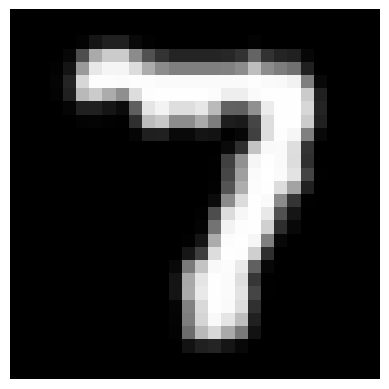

Real value :  7
7


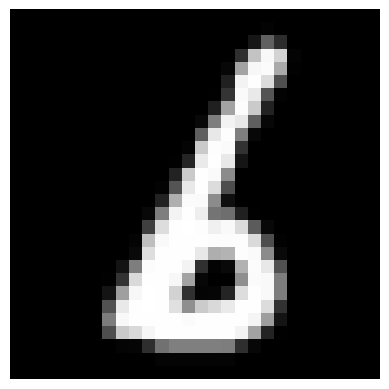

Real value :  b
b


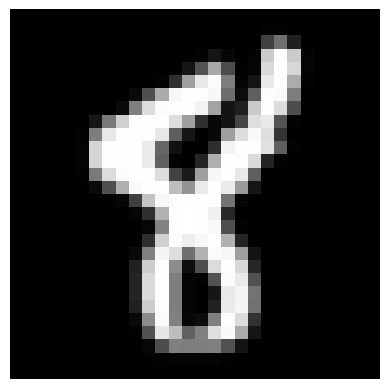

Real value :  8
8


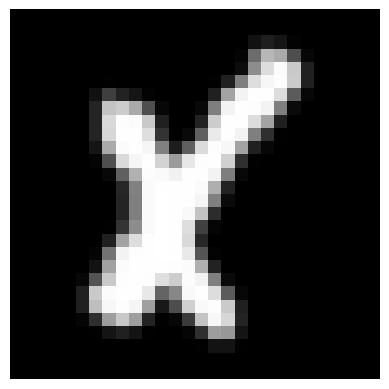

Real value :  x
x


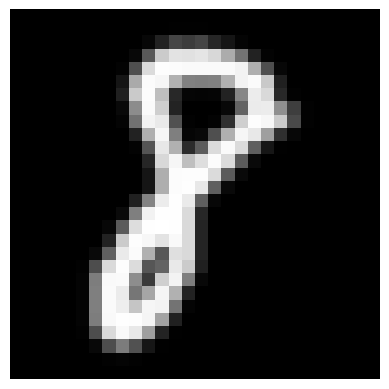

Real value :  8
8


In [12]:
test_random_predictions("dataset/emnist-byclass-test.csv")

In [7]:
from PIL import Image, ImageOps
import numpy as np
import cv2

def preprocess_to_emnist(image_path):
    # Load image and convert to grayscale
    img = Image.open(image_path).convert('L')

    # Invert colors (if background is white)
    img = ImageOps.invert(img)

    # Resize to 28x28
    img = img.resize((28, 28), Image.Resampling.LANCZOS)

    # Convert to numpy array
    img_np = np.array(img)

    # Optional: Center the digit by its moments (like EMNIST style)
    # Compute the center of mass
    moments = cv2.moments(img_np)
    if moments["m00"] != 0:
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
        shiftx = np.round(14 - cx).astype(int)
        shifty = np.round(14 - cy).astype(int)
        M = np.float32([[1, 0, shiftx], [0, 1, shifty]])
        img_np = cv2.warpAffine(img_np, M, (28, 28))

    # Normalize to [0,1]
    img_np = img_np.astype(np.float32) / 255.0

    return img_np

def predict_character(image):
    """
    Predict the character from a single handwritten image,
    accepts either a file path or a preprocessed numpy array.
    
    Args:
        image (str or np.ndarray or PIL.Image): Image file path OR processed numpy array OR PIL image.
    
    Returns:
        str: Predicted character.
    """
    if isinstance(image, str):
        # If a file path, open and preprocess
        pil_img = Image.open(image).convert("L")
        pil_img = ImageOps.invert(pil_img)
        pil_img = pil_img.resize((28, 28), Image.Resampling.LANCZOS)
        img_tensor = transforms.ToTensor()(pil_img).unsqueeze(0).to(device)
    elif isinstance(image, np.ndarray):
        # If numpy array already preprocessed (e.g., 28x28 float)
        # Ensure it's in the right shape and type for ToTensor
        if image.ndim == 2:
            # Convert numpy [0,1] float32 grayscale to PIL Image for consistent transform
            pil_img = Image.fromarray((image * 255).astype(np.uint8))
            img_tensor = transforms.ToTensor()(pil_img).unsqueeze(0).to(device)
        else:
            raise ValueError("NumPy array should be 2D grayscale image")
    elif isinstance(image, Image.Image):
        pil_img = image.convert("L")
        img_tensor = transforms.ToTensor()(pil_img).unsqueeze(0).to(device)
    else:
        raise TypeError("Input must be file path (str), numpy array, or PIL Image")
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_label = torch.max(output.data, 1)
        predicted_label = predicted_label.item()

    return label_to_char(predicted_label)
